In [2]:
# input dataset
input_file = "../data/all_combined_training.csv"
validation_file = "../data/all_combined_validation.csv"

dfName="df1"
processed_data = "../data/"+dfName+"_processed.csv"

model_root= "../artifacts/models/"
data_root="../data/"
fig_root='../figs/'
package_root='../packages/'
root='../'

In [3]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
from scipy.stats import probplot

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# adapted from https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python?scriptVersionId=50985180&cellId=80

import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.compose import (TransformedTargetForecaster, make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, ForecastingGridSearchCV)
from sklearn.linear_model import LinearRegression

from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load
from IPython.core.pylabtools import figsize
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set()
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

In [4]:
# load data
dfName="df2"
df2 = pd.read_csv(processed_data, index_col = 0)
df2.sample(2)
# df1.info()
# df2.datetime[1]
# len(df2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
7870,2013,11,24,22,1193.357750,58.45424,-78.10301,1757,1662.3844,-16.073584,2013-11-24 00:00:00,0.679202,2013-11-24 22:00:00
2413,2013,4,11,13,1185.398667,58.45424,-78.10301,1757,1662.3844,-14.037207,2013-04-11 00:00:00,0.674672,2013-04-11 13:00:00


## Split the dataframe by locationa and sort by datetime

In [5]:
df2.head()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date,kw_cap,datetime
0,2013,1,1,0,1029.780250,58.45424,-78.10301,1757,1662.3844,-18.211905,2013-01-01 00:00:00,0.586101,2013-01-01 00:00:00
1,2013,1,1,1,1017.671833,58.45424,-78.10301,1757,1662.3844,-18.678336,2013-01-01 00:00:00,0.579210,2013-01-01 01:00:00
2,2013,1,1,2,987.965167,58.45424,-78.10301,1757,1662.3844,-18.978430,2013-01-01 00:00:00,0.562302,2013-01-01 02:00:00
3,2013,1,1,3,976.654417,58.45424,-78.10301,1757,1662.3844,-18.901541,2013-01-01 00:00:00,0.555865,2013-01-01 03:00:00
4,2013,1,1,4,957.069500,58.45424,-78.10301,1757,1662.3844,-19.094290,2013-01-01 00:00:00,0.544718,2013-01-01 04:00:00


## Hourly resolution

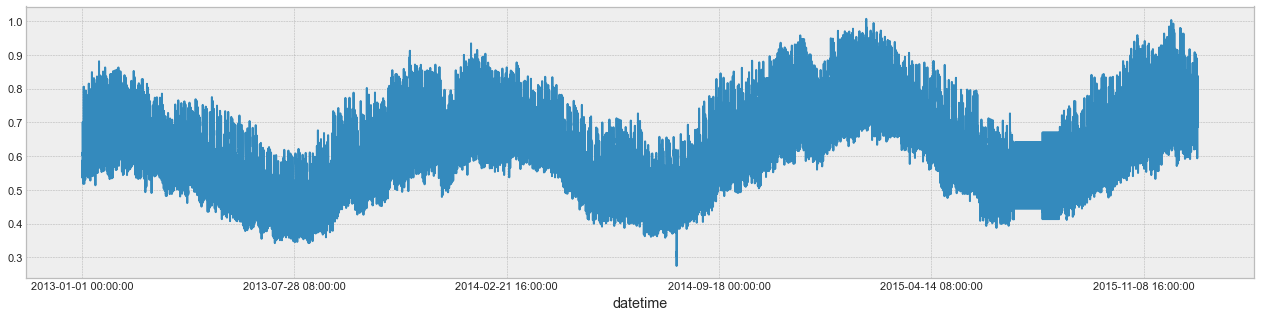

In [6]:
data = df2.set_index('datetime')
data = data['kw_cap']
data.plot(figsize=(22, 5))
plt.show()

In [7]:
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

In [8]:
# tsplot(df2.kw_cap, lags=24*7*52)

## Split the data

In [9]:
s = df2.kw_cap
print(len(s))

26280


In [10]:
test_len = int(len(s)*0.2)
s_train, s_test = temporal_train_test_split(s, test_size=test_len)
test_len

5256

In [11]:
# we have NO missing data
len(s)-365*3*24

0

## Define plot_forecast() function

In [12]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None, extra_title="", train_label="train", test_label="test", 
                  figsize=(12, 4)):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=figsize)
    plt.title(extra_title + f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label=train_label, color="b")
    series_test.plot(label=test_label, color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape


## Define moving average

In [13]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast."""
  mov = np.cumsum(series)
  # the past $window_size number of data points, the series has to be a Numpy array, 
  # which is quite different from Pandas Series
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

In [14]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

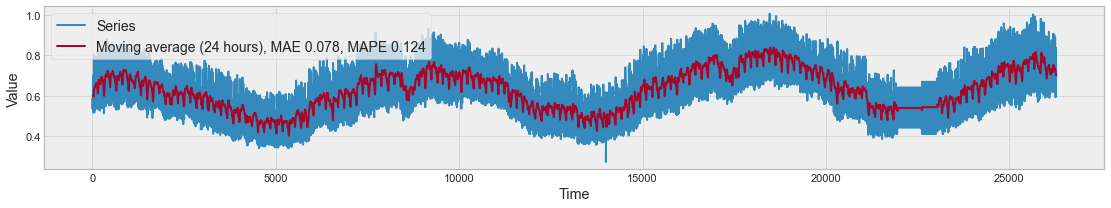

In [15]:
# moving average is calculated as the past window_size number of hours' average
window_size=24*1
moving_avg = moving_average_forecast(np.array(s), window_size)

mape = mean_absolute_percentage_error(moving_avg[-len(s_test):], s_test)
mae = mean_absolute_error(moving_avg[-len(s_test):], s_test)

plt.figure(figsize=(19, 3))
plot_series(range(len(s)), s, label="Series")
plot_series(range(window_size, len(s)), moving_avg, label=f"Moving average ({window_size} hours), MAE {mae:.3f}, MAPE {mape:.3f}")

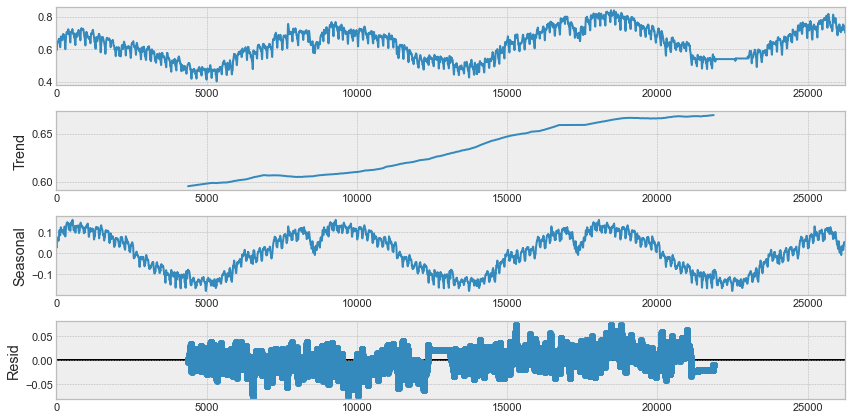

In [16]:
moving_avg = pd.Series(moving_avg)
decomp = seasonal_decompose(moving_avg, model='additive', period=365*24)
plt.rcParams.update({'figure.figsize':(12,6)})
_ = decomp.plot().suptitle('')

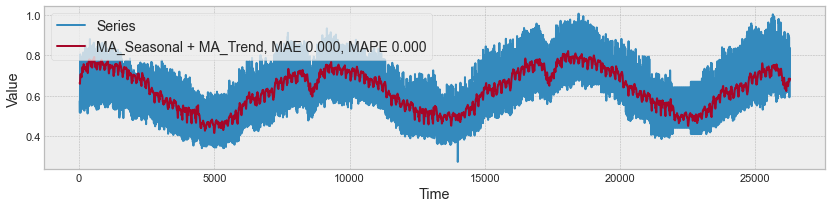

In [17]:
s_sesonal_n_trend=decomp.seasonal+decomp.trend.fillna(decomp.trend.mean())

mape = mean_absolute_percentage_error(s[-len(s_test):], s_test)
mae = mean_absolute_error(s[-len(s_test):], s_test)

plt.figure(figsize=(14, 3))
plot_series(range(len(s)-len(s_sesonal_n_trend), len(s)), s[window_size:], label="Series")
plot_series(range(len(s)-len(s_sesonal_n_trend), len(s)), s_sesonal_n_trend, label=f"MA_Seasonal + MA_Trend, MAE {mae:.3f}, MAPE {mape:.3f}")

## Forecast with `lgbregressor()`
- make_reduction(), During fitting, a sliding-window approach is used to first transform the time series into tabular or panel data, which is then used to fit a tabular or time-series regression estimator. During prediction, the last available data is used as input to the fitted regression estimator to generate forecasts. This is the process where we transform a time series into the `(X,y)` form. However, `window_length` in `make_reduction()` is only `len(X)`.
- `forecaster` is different from `regressor`. In forecasting, past data is used to make temporal forward predictions of a time series. This is notably different from tabular prediction tasks supported by scikit-learn and similar libraries.
- In fit, the composite algorithm uses a sliding window strategy to tabulate the data, and fit the regressor to the tabulated data. In predict, the composite algorithm presents the regressor with the last observed window to obtain predictions.

Check more [here](https://www.sktime.org/en/stable/examples/01_forecasting.html#3.-Advanced-composition-patterns---pipelines,-reduction,-autoML,-and-more)


In [18]:
def create_forecaster_w_desesonalizer(regressor, model="additive", sp=365*5, degree=1, window_length=10*24, strategy="recursive", scitype='infer'):

    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model=model, sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=window_length, strategy=strategy, scitype=scitype),
            ),
        ]
    )

    return forecaster

In [19]:
def regular_forecaster(train, test, forecaster, model_path=None, train_label="train", test_label="test"):

    forecaster.fit(train)

    if model_path:
      dump(forecaster, model_path) 

    # forecasting, note the len(fh) must satisfy some requirements, here we have len(fh)= len(test)
    fh = np.arange(len(test)) + 1
    y_pred = forecaster.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred, train_label=train_label, test_label=test_label, figsize=(14, 4))

    return mae, mape

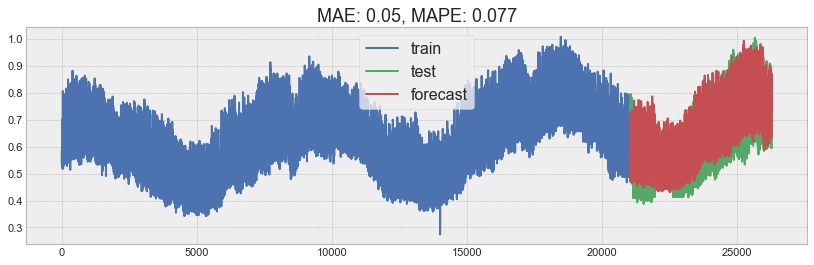

In [20]:
regressor = lgb.LGBMRegressor(n_estimators=30, learning_rate=0.05)
# it's important to have the rigth seasonal_period sp=365*24
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365*24)

s_lgb_mae, s_lgb_mape = regular_forecaster(
    s_train, s_test, forecaster, model_path=model_root+"lgbm_forecaster.pickle"
)

__Predict a whole year ahead__

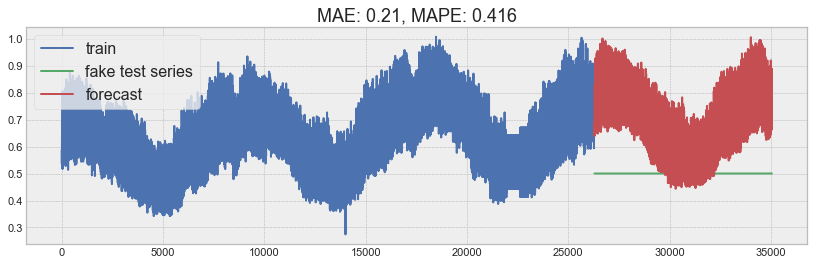

In [29]:
regressor = lgb.LGBMRegressor(n_estimators=30, learning_rate=0.05)
# it's important to have the rigth seasonal_period sp=365*24
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365*24)

fake_test_series = pd.Series(0.5, index=range(len(s), len(s)+365*24))
s_lgb_mae, s_lgb_mape = regular_forecaster(
    s, fake_test_series, forecaster, model_path=model_root+"lgbm_forecaster.pickle", test_label="fake test series"
)

__Moving average seems to perform slightly worse__

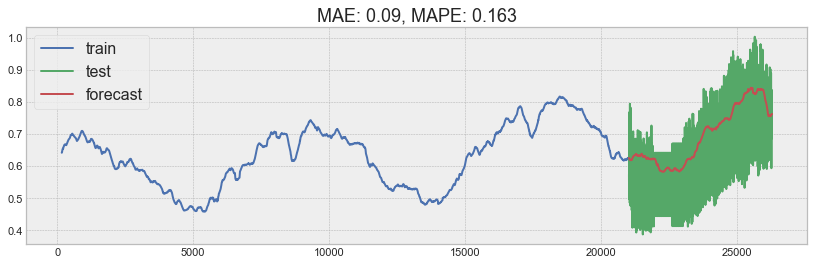

In [23]:
window_size=24*7
ma = moving_average_forecast(np.array(s), window_size)
ma = pd.Series(ma, index=range(window_size,len(s)))
# ma_train should be very close to s_train, it has to satisfy this relation:
# (ma_train - s_train[window_size:]).sum()<<ma_train.sum()
ma_train = ma[:-len(s_test)]

regressor = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05)
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365*24)

_, _ = regular_forecaster(ma_train, s_test, forecaster, model_path=None)

## `Linear` forecaster:

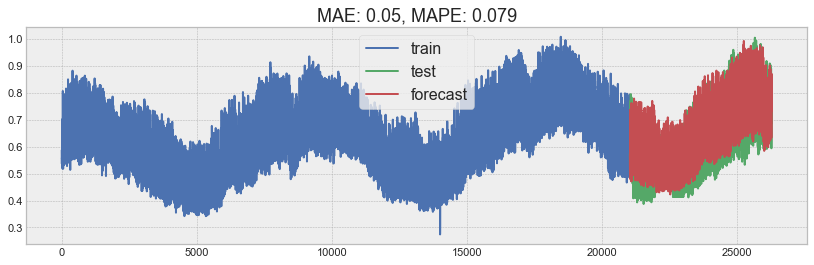

In [31]:
regressor = LinearRegression() # linearRegressor has scitype='tabular-regressor'

forecaster = create_forecaster_w_desesonalizer(regressor, sp=365*24, scitype='tabular-regressor')

_ =regular_forecaster(pd.Series(s_train), pd.Series(s_test), forecaster, model_path=None)

__Predicting a whole year ahead__

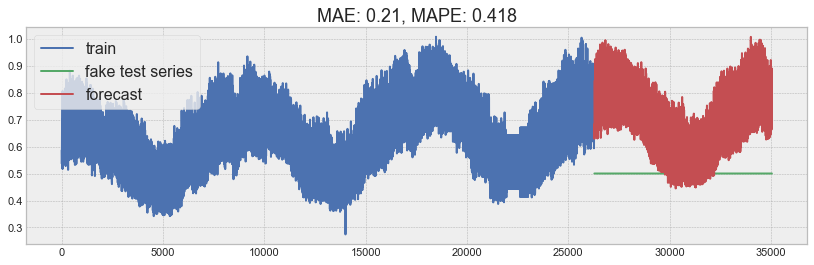

In [35]:
regressor = LinearRegression()
# it's important to have the rigth seasonal_period sp=365*24
forecaster = create_forecaster_w_desesonalizer(regressor,sp=365*24)

fake_test_series = pd.Series(0.5, index=range(len(s), len(s)+365*24))
s_lgb_mae, s_lgb_mape = regular_forecaster(
    s, fake_test_series, forecaster, model_path=model_root+"lgbm_forecaster.pickle", test_label="fake test series"
)

__Moving average seems to perform slightly worse__

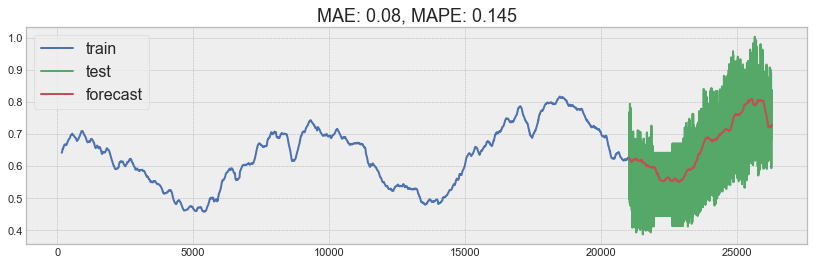

In [25]:
window_size=24*7
ma = moving_average_forecast(np.array(s), window_size)
ma = pd.Series(ma, index=range(window_size,len(s)))
# ma_train should be very close to s1_train, it has to satisfy this relation:
# (ma_train - s1_train[window_size:]).sum()<<ma_train.sum()
ma_train = ma[:-len(s_test)]

regressor = LinearRegression() # linearRegressor has scitype='tabular-regressor'
forecaster = create_forecaster_w_desesonalizer(regressor, sp=365*24, scitype='tabular-regressor')

_, _ = regular_forecaster(
    ma_train, s_test, forecaster, model_path=None
)